# Introduction to Working with NEON AOP Hyperspectral Reflectance Tiles

Hyperspectral remote sensing data can provide useful for capturing information about the environment at the Earth’s surface. In this afternoon's lessons, we will learn how to extract information from a tile (1000m x 1000m x 426 bands) of NEON AOP hyperspectral reflectance data, stored in hdf5 format. If you don't have a strong background in hyperspectral imaging, or would like a quick review, we encourage you to watch the following video: 

<a href="http://www.youtube.com/watch?feature=player_embedded&v=3iaFzafWJQE
" target="_blank"><img src="http://img.youtube.com/vi/3iaFzafWJQE/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="400" height="300" border="10" /></a>

## Objectives
This first tutorial will cover how to read NEON AOP hyperspectral hdf5 dataset using Python. We will develop and practice some tools to manipulate and visualize the spectral data. By the end of this tutorial, you will become familiar with the Jupyter Notebook platform and Python syntax, and learn how to:

1. Import and use Python packages to visualize hyperspectral reflectance data. In this lesson, we will primarily be working with: `numpy, pandas, matplotlib, h5py, and gdal`.
2. Use the Python package `h5py` and the `visititems` functionality to read in an hdf5 file and view how data is stored within the hdf5 format. 
3. Read the reflectance *data ignore value* and *scale factor* and apply these values to produce a cleaned reflectance array.
4. Extract and plot a single band of reflectance data.
5. Plot a histogram of reflectance values to visualize the range and distribution of values.
6. Optional: Subset an hdf5 reflectance file from the full flightline to a smaller region of interest. 
7. Optional: Apply a histogram stretch and adaptive equalization to improve the contrast of an image.  
Before we start coding, make sure you are using the correct version of Python. The `gdal` package is compatible with Python versions 3.5 and earlier. For these lessons we will use Python version 3.5. 

In [1]:
#Check that you are using the correct version of Python (should be 3.5 for these tutorials)
import sys
sys.version

'3.5.4 |Anaconda, Inc.| (default, Nov  8 2017, 14:34:30) [MSC v.1900 64 bit (AMD64)]'

First let's import the required packages:

In [2]:
import numpy as np
import h5py
import gdal, osr, os
import matplotlib.pyplot as plt

Next, set display preferences so that plots are inline (meaning any images you output from your code will show up below the cell in the notebook) and turn off plot warnings:

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Read hdf5 file into Python

```f = h5py.File('file.h5','r')``` reads in an h5 file to the variable f. 

**TIP:** We will be using a number of built-in and user-defined functions and methods throughout these tutorials. If you are uncertain what a certain function does, or how to call it, you can type 
**?** at the end of the function or method and run the cell (Cell > Run Cells or Shift Enter), which will pop up a window at the bottom of the notebook displaying the ```docstrings```, which includes information about the function and usage. We encourage you to use this tool throughout the tutorial as you come across funcitons you are unfamiliar with. Let's try this out with `h5py.File`:

In [4]:
h5py.File?

Now that we have an idea of how to use h5py to read in an h5 file, let's try it out. Note that if the h5 file is stored in a different directory than where you are running your notebook, you need to include the path (either relative or absolute) to the directory where that data file is stored. We can use `os.path.join` to create the full path of the file. You will need to modify the `data_path` variable to point to the directory where you are storing your h5 data.

In [5]:
data_path = r'C:\Users\bhass\Documents\GitHub\NEON_RSDI\RSDI_2018\data';
f = h5py.File(os.path.join(data_path,'NEON_D02_SERC_DP3_368000_4306000_reflectance.h5'),'r') 
#f = h5py.File('../data/NEON_D02_SERC_DP3_368000_4306000_reflectance.h5','r') 

## Explore NEON AOP HDF5 Reflectance Files

We can look inside the HDF5 dataset with the ```h5py visititems``` function. The ```list_dataset``` function defined below displays all datasets stored in the hdf5 file and their locations within the hdf5 file:

In [6]:
#list_dataset lists the names of datasets in an hdf5 file
def list_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name)

f.visititems(list_dataset)

SERC/Reflectance/Metadata/Ancillary_Imagery/Aerosol_Optical_Depth
SERC/Reflectance/Metadata/Ancillary_Imagery/Aspect
SERC/Reflectance/Metadata/Ancillary_Imagery/Cast_Shadow
SERC/Reflectance/Metadata/Ancillary_Imagery/Dark_Dense_Vegetation_Classification
SERC/Reflectance/Metadata/Ancillary_Imagery/Data_Selection_Index
SERC/Reflectance/Metadata/Ancillary_Imagery/Haze_Cloud_Water_Map
SERC/Reflectance/Metadata/Ancillary_Imagery/Illumination_Factor
SERC/Reflectance/Metadata/Ancillary_Imagery/Path_Length
SERC/Reflectance/Metadata/Ancillary_Imagery/Sky_View_Factor
SERC/Reflectance/Metadata/Ancillary_Imagery/Slope
SERC/Reflectance/Metadata/Ancillary_Imagery/Smooth_Surface_Elevation
SERC/Reflectance/Metadata/Ancillary_Imagery/Visibility_Index_Map
SERC/Reflectance/Metadata/Ancillary_Imagery/Water_Vapor_Column
SERC/Reflectance/Metadata/Ancillary_Imagery/Weather_Quality_Indicator
SERC/Reflectance/Metadata/Coordinate_System/Coordinate_System_String
SERC/Reflectance/Metadata/Coordinate_System/EPSG C

You can see that there is a lot of information stored inside this reflectance hdf5 file. Most of this information is *metadata* (data about the reflectance data), for example, this file stores input parameters used in the atmospheric correction. For this introductory lesson, we will only work with two of these datasets, the reflectance data (hyperspectral cube), and the corresponding geospatial information, stored in Metadata/Coordinate_System:

- `SERC/Reflectance/Reflectance_Data`
- `SERC/Reflectance/Metadata/Coordinate_System/`

We can also display the name, shape, and type of each of these datasets using the `ls_dataset` function defined below, which is also called with the `visititems` method: 

In [7]:
#ls_dataset displays the name, shape, and type of datasets in hdf5 file
def ls_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(node)

In [8]:
#to see what the visititems methods does, type ? at the end:
f.visititems?

In [9]:
f.visititems(ls_dataset)

<HDF5 dataset "Aerosol_Optical_Depth": shape (1000, 1000), type "<i2">
<HDF5 dataset "Aspect": shape (1000, 1000), type "<f4">
<HDF5 dataset "Cast_Shadow": shape (1000, 1000), type "|u1">
<HDF5 dataset "Dark_Dense_Vegetation_Classification": shape (1000, 1000), type "|u1">
<HDF5 dataset "Data_Selection_Index": shape (1000, 1000), type "<i4">
<HDF5 dataset "Haze_Cloud_Water_Map": shape (1000, 1000), type "|u1">
<HDF5 dataset "Illumination_Factor": shape (1000, 1000), type "|u1">
<HDF5 dataset "Path_Length": shape (1000, 1000), type "<f4">
<HDF5 dataset "Sky_View_Factor": shape (1000, 1000), type "|u1">
<HDF5 dataset "Slope": shape (1000, 1000), type "<f4">
<HDF5 dataset "Smooth_Surface_Elevation": shape (1000, 1000), type "<f4">
<HDF5 dataset "Visibility_Index_Map": shape (1000, 1000), type "|u1">
<HDF5 dataset "Water_Vapor_Column": shape (1000, 1000), type "<f4">
<HDF5 dataset "Weather_Quality_Indicator": shape (1000, 1000, 3), type "|u1">
<HDF5 dataset "Coordinate_System_String": shap

Now that we can see the structure of the hdf5 file, let's take a look at some of the information that is stored inside. Let's start by extracting the reflectance data, which is nested under `SERC/Reflectance/Reflectance_Data`:  

In [10]:
serc_refl = f['SERC']['Reflectance']
print(serc_refl)

<HDF5 group "/SERC/Reflectance" (2 members)>


The two members of the HDF5 group `/SERC/Reflectance` are `Metadata` and `Reflectance_Data`. Let's save the reflectance data as the variable serc_reflArray:

In [11]:
serc_reflArray = serc_refl['Reflectance_Data']
print(serc_reflArray)

<HDF5 dataset "Reflectance_Data": shape (1000, 1000, 426), type "<i2">


We can extract the size of this reflectance array that we extracted using the `shape` method:

In [12]:
refl_shape = serc_reflArray.shape
print('SERC Reflectance Data Dimensions:',refl_shape)

SERC Reflectance Data Dimensions: (1000, 1000, 426)


This 3-D shape (1000,1000,426) corresponds to (y,x,bands), where (x,y) are the dimensions of the reflectance array in pixels. Hyperspectral data sets are often called "cubes" to reflect this 3-dimensional shape.

<p>
<img src="HyperspectralDataCube.png" style="width: 500px;"/>
</p>


NEON hyperspectral data contain around 426 spectral bands, and when working with tiled data, the spatial dimensions are 1000 x 1000, where each pixel represents 1 meter. Now let's take a look at the wavelength values. First, we will extract wavelength information from the `serc_refl` variable that we created:

In [13]:
#define the wavelengths variable
wavelengths = serc_refl['Metadata']['Spectral_Data']['Wavelength']

#View wavelength information and values
print('wavelengths:',wavelengths)

wavelengths: <HDF5 dataset "Wavelength": shape (426,), type "<f4">


We can then use `numpy` (imported as `np`) to see the minimum and maximum wavelength values:

In [14]:
# Display min & max wavelengths
print('min wavelength:', np.amin(wavelengths),'nm')
print('max wavelength:', np.amax(wavelengths),'nm')

min wavelength: 383.534 nm
max wavelength: 2511.89 nm


Finally, we can determine the band widths (distance between center bands of two adjacent bands). Let's try this for the first two bands and the last two bands. Remember that Python uses 0-based indexing (`[0]` represents the first value in an array), and note that you can also use negative numbers to splice values from the end of an array (`[-1]` represents the last value in an array).

In [15]:
#show the band widths between the first 2 bands and last 2 bands 
print('band width between first 2 bands =',(wavelengths.value[1]-wavelengths.value[0]),'nm')
print('band width between last 2 bands =',(wavelengths.value[-1]-wavelengths.value[-2]),'nm')

band width between first 2 bands = 5.0079 nm
band width between last 2 bands = 5.00781 nm


The center wavelengths recorded in this hyperspectral cube range from `383.66 - 2511.94 nm`, and each band covers a range of ~`5 nm`. Now let's extract spatial information, which is stored under `SERC/Reflectance/Metadata/Coordinate_System/Map_Info`:

In [16]:
serc_mapInfo = serc_refl['Metadata']['Coordinate_System']['Map_Info']
print('SERC Map Info:',serc_mapInfo.value)

SERC Map Info: b'UTM,  1.000,  1.000,       368000.00,       4307000.0,       1.0000000,       1.0000000,  18,  North,  WGS-84,  units=Meters, 0'


Here we can spatial information about the reflectance data. Below is a break down of what each of these values means:

- `UTM` - coordinate system (Universal Transverse Mercator)
- `1.000, 1.000` - 
- `368000.000, 4307000.0` - UTM coordinates (meters) of the map origin, which refers to the upper-left corner of the image  (xMin, yMax). 
- `1.0000000, 1.0000000` - pixel resolution (meters)
- `18` - UTM zone
- `N` - UTM hemisphere (North for all NEON sites)
- `WGS-84` - reference ellipoid

**Note**: The letter `b` that appears before UTM signifies that the variable-length string data is stored in `b`inary format when it is written to the hdf5 file. Don't worry about it for now, as we will convert the numerical data we need into floating point numbers. For more information on hdf5 strings, you can refer to: http://docs.h5py.org/en/latest/strings.html

Let's extract relevant information from the `Map_Info` metadata to define the spatial extent of this dataset. To do this, we can use the `split` method to break up this string into separate values:

In [17]:
#First convert mapInfo to a string
mapInfo_string = str(serc_mapInfo.value) #convert to string

#see what the split method does
mapInfo_string.split?

In [18]:
#split the strings using the separator "," 
mapInfo_split = mapInfo_string.split(",") 
print(mapInfo_split)

["b'UTM", '  1.000', '  1.000', '       368000.00', '       4307000.0', '       1.0000000', '       1.0000000', '  18', '  North', '  WGS-84', '  units=Meters', " 0'"]


Now we can extract the spatial information we need from the map info values, convert them to the appropriate data type (float) and store it in a way that will enable us to access and apply it later when we want to plot the data: 

In [19]:
#Extract the resolution & convert to floating decimal number
res = float(mapInfo_split[5]),float(mapInfo_split[6])
print('Resolution:',res)

Resolution: (1.0, 1.0)


In [20]:
#Extract the upper left-hand corner coordinates from mapInfo
xMin = float(mapInfo_split[3]) 
yMax = float(mapInfo_split[4])

In [21]:
#Calculate the xMax and yMin values from the dimensions
xMax = xMin + (refl_shape[1]*res[0]) #xMax = left edge + (# of columns * x pixel resolution)
yMin = yMax - (refl_shape[0]*res[1]) #yMin = top edge - (# of rows * y pixel resolution)

In [22]:
#Define extent as a tuple:
serc_ext = (xMin, xMax, yMin, yMax)
print('serc_ext:',serc_ext)
print('serc_ext type:',type(serc_ext))

#Define extent as dictionary (key-value pair):
serc_extDict = {}
serc_extDict['xMin'] = xMin
serc_extDict['xMax'] = xMax
serc_extDict['yMin'] = yMin
serc_extDict['yMax'] = yMax
print('serc_extDict:',serc_extDict)
print('serc_extDict type:',type(serc_extDict))

serc_ext: (368000.0, 369000.0, 4306000.0, 4307000.0)
serc_ext type: <class 'tuple'>
serc_extDict: {'xMax': 369000.0, 'yMax': 4307000.0, 'yMin': 4306000.0, 'xMin': 368000.0}
serc_extDict type: <class 'dict'>


## Extract a single band from the array

While it is useful to have all the data contained in a hyperspectral cube, it is difficult to visualize all this information at once. We can extract a single band (representing a ~5nm band, approximating a single wavelength) from the cube by using splicing as follows. Note that we have to cast the reflectance data into the type `float`. 

In [23]:
b56 = serc_reflArray[:,:,55].astype(float)
print('b56 type:',type(b56))
print('b56 shape:',b56.shape)
print('Band 56 Reflectance:\n',b56)

b56 type: <class 'numpy.ndarray'>
b56 shape: (1000, 1000)
Band 56 Reflectance:
 [[  254.   241.   250. ...,   334.   313.   330.]
 [  253.   260.   624. ...,   281.   311.   291.]
 [  262.   413.  1050. ...,   295.   349.   280.]
 ..., 
 [  281.   231.   292. ...,  1168.   978.   916.]
 [  240.   222.   189. ...,  1654.  1728.  1694.]
 [  319.   329.   317. ...,  1176.  1466.  1582.]]


Here we can see that we extracted a 2-D array (1000 x 1000) of the scaled reflectance data corresponding to the wavelength band 56. Before we can use the data, we need to clean it up a little. We'll show how to do this below. 

## Clean reflectance data: apply the scale factor and data ignore value.

This array represents the scaled reflectance for band 56. Recall from exploring the HDF5 data in HDFViewer that NEON AOP reflectance data uses a `Data_Ignore_Value` of `-9999` to represent missing data (often called `NaN`), and a reflectance `Scale_Factor` of `10000.0` in order to save disk space (can use lower precision this way). 

<p>
<img src="hdfview_SERCrefl.png" style="width: 650px;"/>
</p>

We can extract and apply the `Data_Ignore_Value` and `Scale_Factor` as follows:

In [24]:
#View and apply scale factor and data ignore value
scaleFactor = serc_reflArray.attrs['Scale_Factor']
noDataValue = serc_reflArray.attrs['Data_Ignore_Value']
print('Scale Factor:',scaleFactor)
print('Data Ignore Value:',noDataValue)

b56[b56==int(noDataValue)]=np.nan
b56 = b56/scaleFactor
print('Cleaned Band 56 Reflectance:\n',b56)

Scale Factor: 10000.0
Data Ignore Value: -9999.0
Cleaned Band 56 Reflectance:
 [[ 0.0254  0.0241  0.025  ...,  0.0334  0.0313  0.033 ]
 [ 0.0253  0.026   0.0624 ...,  0.0281  0.0311  0.0291]
 [ 0.0262  0.0413  0.105  ...,  0.0295  0.0349  0.028 ]
 ..., 
 [ 0.0281  0.0231  0.0292 ...,  0.1168  0.0978  0.0916]
 [ 0.024   0.0222  0.0189 ...,  0.1654  0.1728  0.1694]
 [ 0.0319  0.0329  0.0317 ...,  0.1176  0.1466  0.1582]]


## Plot single reflectance band

Now we can plot this band using the Python package ```matplotlib.pyplot```, which we imported at the beginning of the lesson as ```plt```. Note that the default colormap is jet unless otherwise specified. You can explore using different colormaps on your own; see https://matplotlib.org/examples/color/colormaps_reference.html for other options. 

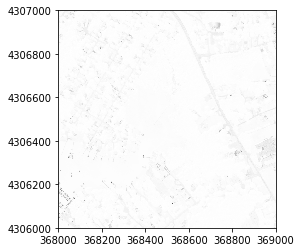

In [25]:
serc_plot = plt.imshow(b56,extent=serc_ext,cmap='Greys') 

We can see that this image looks pretty washed out. To see why this is, it helps to look at the range and distribution of reflectance values that we are plotting. We can do this by making a histogram. 

## Plot histogram of reflectance data values

We can plot a histogram using the `matplotlib.pyplot.hist` function. Note that this function won't work if there are any NaN values, so we can ensure we are only plotting the real data values using the call below. You can also specify the # of bins you want to divide the data into. 

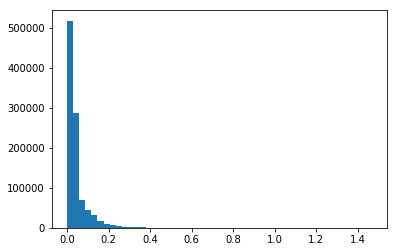

In [26]:
plt.hist(b56[~np.isnan(b56)],50); #50 signifies the # of bins

We can see that most of the reflectance values are < 0.4. In order to show more contrast in the image, we can adjust the colorlimit (`clim`) to 0-0.4:

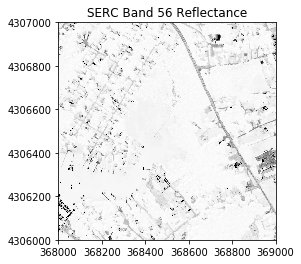

In [27]:
serc_plot = plt.imshow(b56,extent=serc_ext,cmap='Greys',clim=(0,0.4)) 
plt.title('SERC Band 56 Reflectance');

Here you can see that adjusting the colorlimit displays features (eg. roads, buildings) much better than when we set the colormap limits to the entire range of reflectance values. 

## OPTIONAL: Basic Image Processing -- Contrast Stretch & Histogram Equalization 

We can also try out some basic image processing to better visualize the reflectance data using the ```ski-image``` package. 

Histogram equalization is a method in image processing of contrast adjustment using the image's histogram. Stretching the histogram can improve the contrast of a displayed image, as we will show how to do below. 

<p>
<img src="histogram_equalization.png" style="width: 300px;"/>
</p>

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html

These tutorials were adapted from the following `skikit-image` tutorial:
http://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py

Below we demonstrate a widget to interactively display different linear contrast stretches:

### Explore the contrast stretch feature interactively using IPython widgets: 

In [28]:
from skimage import exposure
from IPython.html.widgets import *

def linearStretch(percent):
    pLow, pHigh = np.percentile(b56[~np.isnan(b56)], (percent,100-percent))
    img_rescale = exposure.rescale_intensity(b56, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=serc_ext,cmap='gist_earth') 
    #cbar = plt.colorbar(); cbar.set_label('Reflectance')
    plt.title('SERC Band 56 \n Linear ' + str(percent) + '% Contrast Stretch'); 
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree
    
interact(linearStretch,percent=(0,100,1))

interactive(children=(IntSlider(value=50, description='percent'), Output()), _dom_classes=('widget-interact',))

<function __main__.linearStretch>